# Computing energy histogram and specific test images

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import torch

from tqdm.notebook import tqdm, trange

from main import *

params = {
      'text.usetex': True,
      'font.family': 'sans serif'
}
matplotlib.rcParams.update(params)

## Load ImageNet64 model

In [4]:
def load_exp(name, step="last", log=True, dataloaders=False):
    """ Load an experiment with a given name. step can be an integer, "best", or "last" (default). """
    exp_dir = Path("models") / name

    with open(exp_dir / "args.json") as f:
        args_dict = json.load(f)

    ctx = TrainingContext(**args_dict, step=step, key_remap=None, seed=None, dataloaders=dataloaders, writer=False)
    if log:
        print(f"{name}: retrieved model at step {ctx.step} and test loss {ctx.test_perf.loss:.2e}")

    # Disable DataParallel (needed for Hessian computation)
    ctx.model.network = ctx.model.network.module

    # Put in eval mode and disable gradients with respect to all parameters.
    ctx.model.eval()
    for p in ctx.model.parameters():
        p.requires_grad = False

    return ctx

ctx = load_exp("finalclean_imagenet64_grayscale_lr0.0005_1Msteps10decays", dataloaders=True)
device = ctx.device
dataset_info = ctx.dataset_info
d = dataset_info.dimension
# Dataloaders have horizontal flips.
train_dataloader_grayscale = ctx.new_dataloader(train=True, batch_size=1024)
test_dataloader_grayscale = ctx.new_dataloader(train=False, batch_size=1024)

finalclean_imagenet64_grayscale_lr0.0005_1Msteps10decays: retrieved model at step 1000000 and test loss 4.57e-01


## Compute energies

In [5]:
# Compare their probabilities on clean grayscale images

def samples_energy(dataloader, t=0):
    ctx.time_tracker.reset()

    xs = []
    es = []
    for x in tqdm(dataloader):
        x = x[0]
        xs.append(x.cpu())
        clean = x.cuda()
        input = model_input(clean, noise_level=t)
        ctx.time_tracker.switch("forward")
        output = ctx.model(input, compute_scores=False, create_graph=False)  # (B,)
        es.append(output.energy.cpu())

    print(ctx.time_tracker.pretty_print())

    xs = torch.cat(xs, dim=0)
    es = torch.cat(es, dim=0)
    return xs, es

# Compute normalization constant by computing average energy at large noise level (for accuracy)
# t = 1e3
# _, energies_t = samples_energy(test_dataloader_grayscale, t=t)
# log_normalization_constant = d/2 * np.log(2 * np.pi * np.e * t) - energies_t.mean()
# ctx.model.log_normalization_constant = log_normalization_constant

# imgs_test, energies_test = samples_energy(test_dataloader_grayscale, t=0)
# imgs_train, energies_train = samples_energy(train_dataloader_grayscale, t=0)
# torch.save((log_normalization_constant, energies_test), "outputs/energies_test.pt")
log_normalization_constant, energies_test = torch.load("outputs/energies_test.pt")
print(f"Log normalization constant: {log_normalization_constant.item():.4}")
ctx.model.log_normalization_constant = log_normalization_constant

c = lambda e: LogTensor(e, d).to(base="dBs", sign="logp", per_dimension=True)

Log normalization constant: 5.845e+03


In [6]:
# print(f"{len(energies_train['grayscale']):,} train images and {len(energies_test['grayscale']):,} test images")
# Outputs: 1,281,167 train images and 50,000 test images

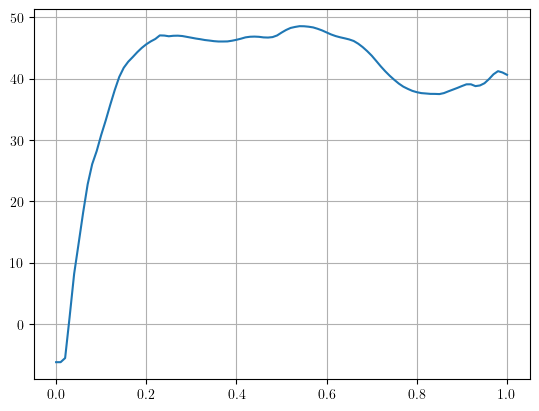

Max 48.58 at 0.5 47.54


In [7]:
# Energy of constant images.
a = torch.linspace(0, 1, 101)
constants = (a[:, None, None, None] * torch.ones((1, 1, 64, 64))).to(device)  # (N, 1, H, W)
logp = c(ctx.model(model_input(constants), compute_scores=False).energy)
plot_lines(logp, x=a)
logp_best_cst = logp.max()
logp_mid_cst = logp[len(a)//2]
print(f"Max {logp_best_cst.item():.2f} at 0.5 {logp_mid_cst.item():.2f}")

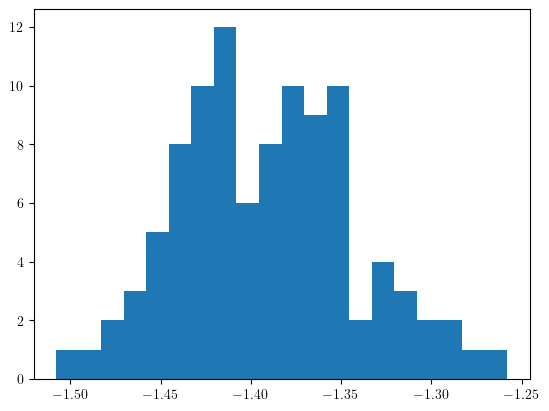

Mean logp: -1.39


In [8]:
# Energy of uniform noise.
noise = torch.rand((100, 1, 64, 64), device=device)
logp = c(ctx.model(model_input(noise), compute_scores=False).energy)
plt.hist(logp.cpu(), bins=20)
plt.show()
logp_noise_mean = logp.mean()
print(f"Mean logp: {logp_noise_mean.item():.2f}")

## Sorted images

Idxs: tensor([21143, 34295, 42627, 47510,  8718,  4375,  1266, 47346, 11592, 36426,
        31424, 17305, 14457, 39755, 41191])
Log p: 2.55 5.00 7.46 9.92 12.38 14.83 17.29 19.75 22.20 24.65 27.12 29.62 32.03 34.45 36.95
<class 'numpy.ndarray'> (15, 64, 64, 3)


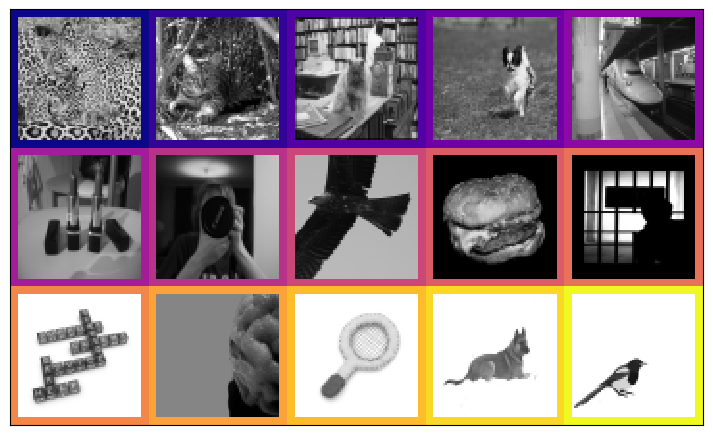

In [9]:
n = 15
colormap = "plasma"
colors = matplotlib.colormaps.get_cmap(colormap)(np.linspace(0, 1, n))[:, :3]  # (N, 3)

logp_test = c(energies_test)
idx_sorted = torch.argsort(logp_test)
logp_sorted = logp_test[idx_sorted]

logp = torch.linspace(logp_sorted[0], logp_sorted[-1], n)
idx_after_sort = torch.stack([torch.argmin(torch.abs(logp_sorted - lp)) for lp in logp])

idx_ref = idx_sorted[idx_after_sort]
logp_ref = logp_test[idx_ref]
print("Idxs:", idx_ref)
print("Log p:", " ".join(f"{lp.item():.2f}" for lp in logp_ref))

import torchvision.transforms.v2 as v2
from PIL import Image
color_transforms = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
grayscale_transforms = v2.Compose([v2.Grayscale(), v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])
apply = lambda t, x: torch.stack([t(Image.fromarray(xx)) for xx in x], dim=0)

imgs_ref = test_dataloader_grayscale.dataset.data[idx_ref]  # (N, H, W, C) uint8 numpy array
print(type(imgs_ref), imgs_ref.shape)
imgs_ref_color = apply(color_transforms, imgs_ref)
imgs_ref_grayscale = apply(grayscale_transforms, imgs_ref)

a = 4
boxes = torch.zeros((n, 3, 64 + 2*a, 64 + 2*a)) + torch.from_numpy(colors)[:, :, None, None]
boxes[:, :, a:-a, a:-a] = imgs_ref_grayscale
all_imgs_ref = rearrange(boxes, "(n1 n2) c h w -> (n1 h) (n2 w) c", n1=3)
plot_img(all_imgs_ref, inches_per_pixel=0.025)

img = (255 * all_imgs_ref).to(torch.uint8).contiguous().numpy()
image = Image.fromarray(img)
image.save("outputs/imgs_ref.png")

In [9]:
imgs_test = apply(grayscale_transforms, test_dataloader_grayscale.dataset.data)
imgs_sorted = imgs_test[idx_sorted]

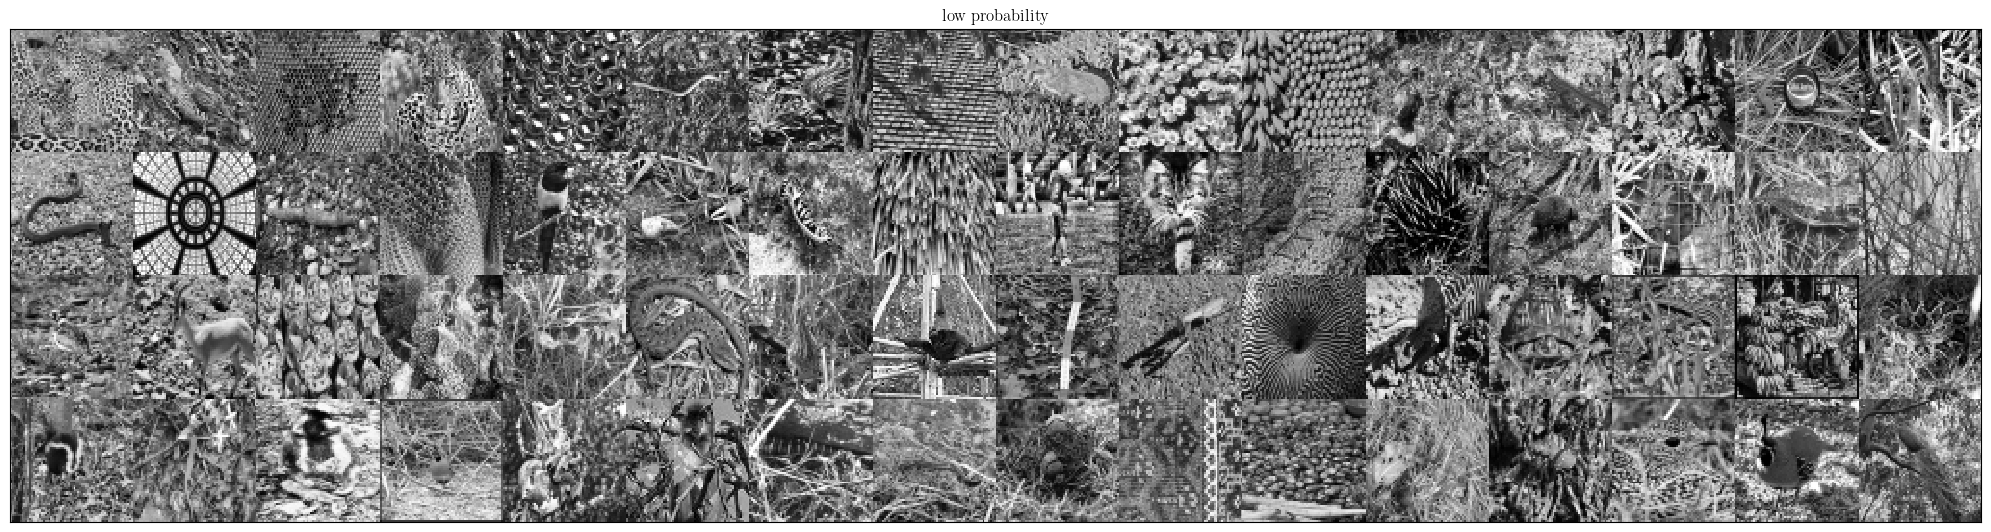

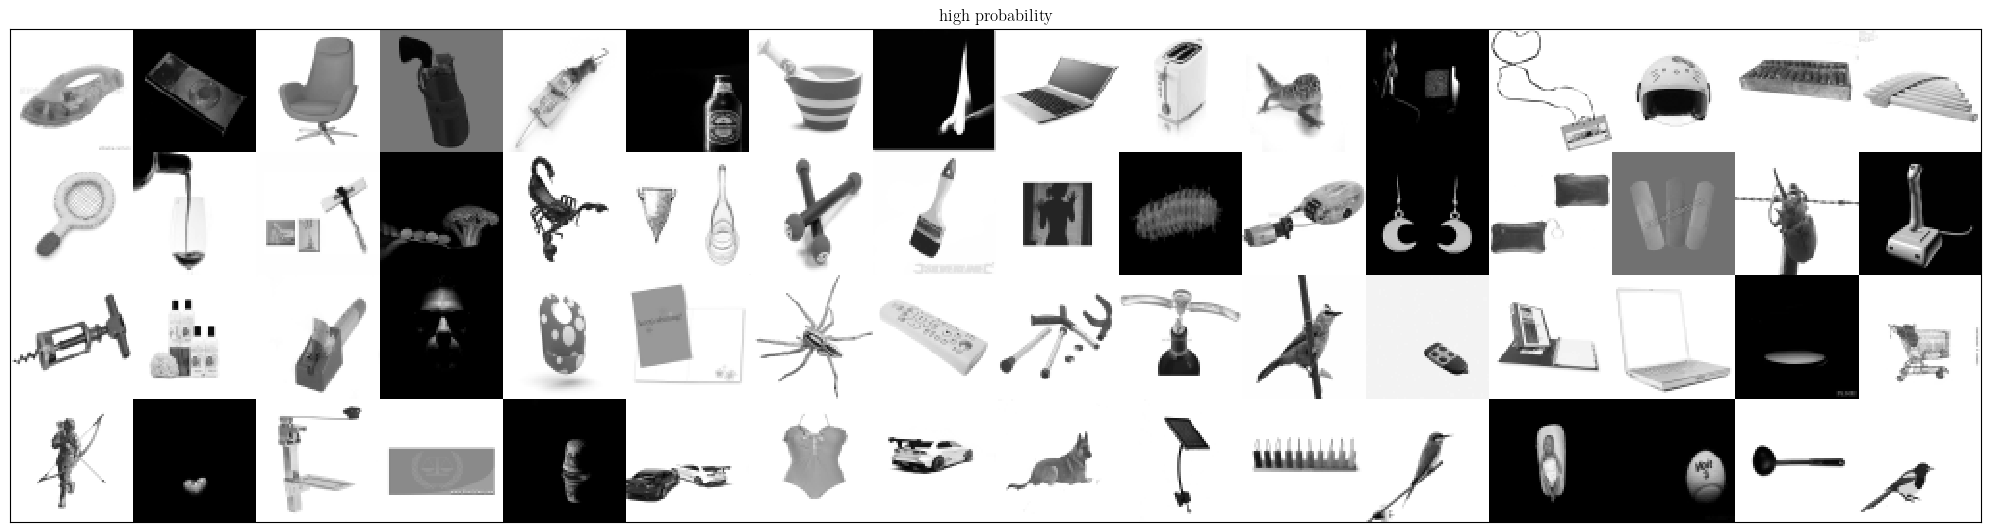

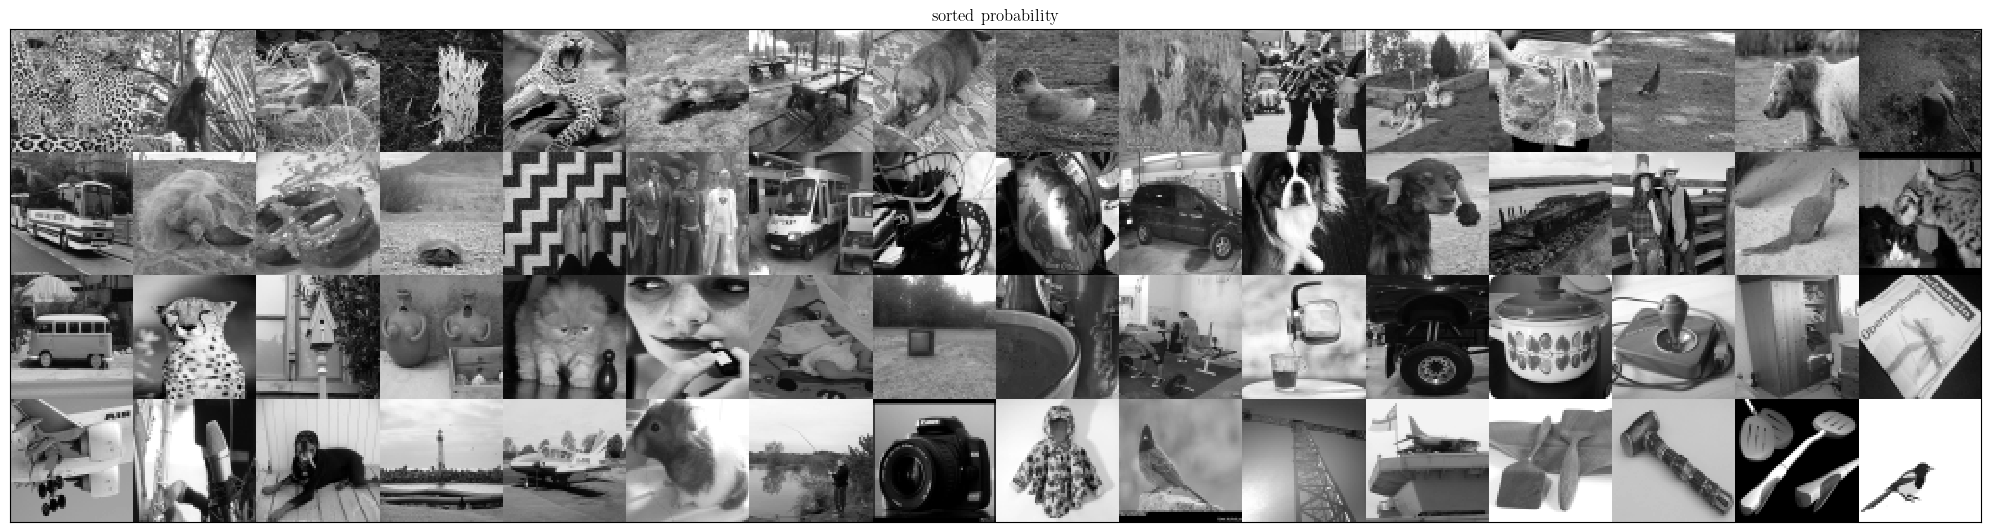

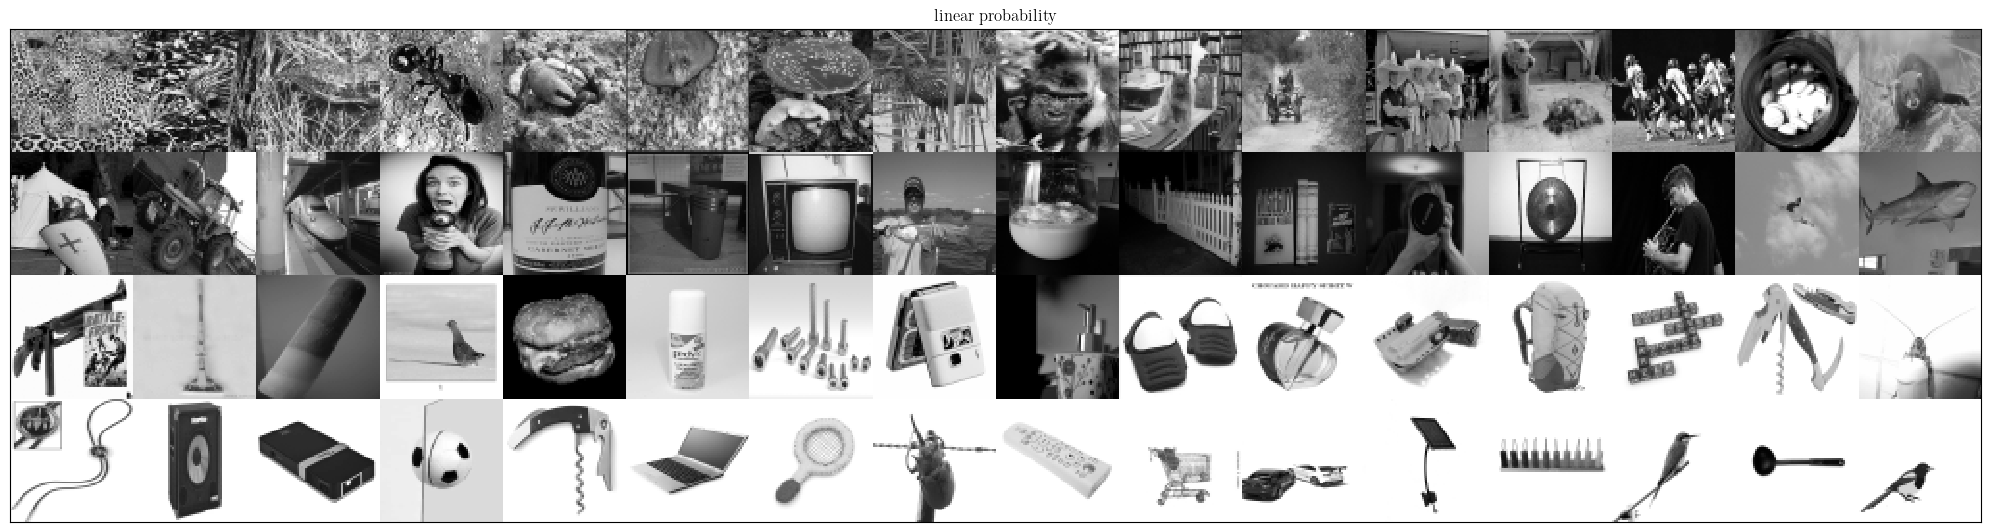

In [ ]:
num_cols = 16
num_rows = 4
num_imgs = num_cols * num_rows

logp = torch.linspace(logp_sorted[0], logp_sorted[-1], num_imgs)
idx_after_sort = torch.stack([torch.argmin(torch.abs(logp_sorted - lp)) for lp in logp])

for name, subset in dict(
    low=np.s_[:num_imgs],
    high=np.s_[-num_imgs:],
    sorted=torch.linspace(0, len(imgs_sorted) - 1, num_imgs, dtype=torch.int),
    linear=idx_after_sort,
).items():
    img = rearrange(imgs_sorted[subset], "(n1 n2) 1 h w -> (n1 h) (n2 w)", n1=num_rows, n2=num_cols)
    plot_img(img, inches_per_pixel=0.025, title=f"{name} probability", cmap="gray")
    img = (255 * img).to(torch.uint8).contiguous().numpy()
    image = Image.fromarray(img)
    image.save(f"outputs/imgs_{name}_prob.png")

## Histograms

Test
Log p moments in dB/dim: median 10.67 mean 11.43 std 4.17
Gumbel parameters in dB/dim: location 9.57 scale 3.17
Corresponding Fréchet parameters (per dim): scale 9.05 shape 1.37


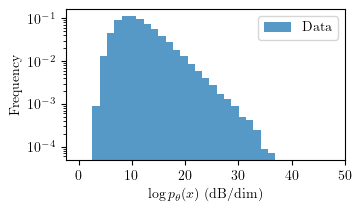

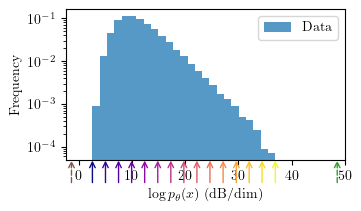

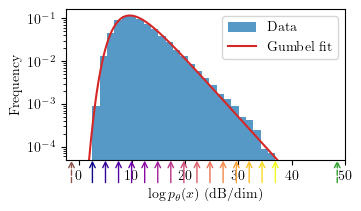

In [15]:
# Compare histogram of empirical energy distribution with Gumbel fit  (from grayscale images)
for train_test, energies in [
    # ("Train", energies_train),
    ("Test", energies_test),
]:
    print(train_test)
    logp = LogTensor(energies, d).to(base="dBs", sign="logp", per_dimension=True)
    median = logp.median().item()
    mean = logp.mean().item()
    std = logp.std().item()
    print(f"Log p moments in dB/dim: median {median:.2f} mean {mean:.2f} std {std:.2f}")

    def gumbel_fit(data, n_iters, lr):
        # Intialize from moment matching
        scale = torch.sqrt(data.std() ** 2 * 6 / np.pi ** 2)
        location = data.mean() - scale * np.euler_gamma

        # Optimize
        loss_values = []
        location.requires_grad = True
        scale.requires_grad = True
        optimizer = torch.optim.Adam([location, scale], lr=lr)
        for _ in range(n_iters):
            data_standardized = (data - location) / scale
            loss = torch.mean(data_standardized + torch.exp(-data_standardized)) + torch.log(scale)
            loss_values.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # if n_iters > 0:
        #     plot_lines(loss_values, title="Gumbel fit loss", xscale="log")
        return location.item(), scale.item()


    location, scale = gumbel_fit(logp, n_iters=100, lr=0.01)
    print(f"Gumbel parameters in dB/dim: location {location:.2f} scale {scale:.2f}")
    print(f"Corresponding Fréchet parameters (per dim): scale {10 ** (location / 10):.2f} shape {10 / (scale * np.log(10)):.2f}")

    for step in range(3):  # Animate figure:
        plt.figure(figsize=(3.5, 2), layout="constrained")
        lp = logp.cpu().numpy()
        subplots = [
            # False,
            True]
        for i, log in enumerate(subplots):
            plt.subplot(1, len(subplots), i+1)
            plt.hist(lp, bins=50 if train_test == "Train" else 25, density=True, label=r"Data", log=log, alpha=0.75, rasterized=True)
            ylim = plt.ylim()

            # Also plot Gumbel pdf
            xmin, xmax = -2.5, 50
            x = torch.linspace(xmin, xmax, 1000)
            if step >= 2:
                dist = torch.distributions.Gumbel(location, scale)
                prob = dist.log_prob(x).exp()
                plt.plot(x, prob, label="Gumbel fit", color="tab:red")

            if step >= 1:
                for (x, color) in [(logp_best_cst, "tab:green"), (logp_noise_mean, "tab:brown")] + list(zip(logp_ref, colors)):
                    # plt.axvline(x.item(), color=color)
                    a = 0.05
                    linestyle = "--" if isinstance(color, str) else "-"
                    # plt.arrow(x, a, 0, a, length_includes_head=True, )
                    plt.annotate("", xy=(x.item(), ylim[0] * 1.1 if log else 0.002), xytext=(x.item(), ylim[0] / 4 if log else -0.02),
                                 arrowprops=dict(color=color, arrowstyle="->", linestyle=linestyle), xycoords="data")

            plt.xlim(xmin, xmax)
            plt.ylim(*ylim)
            plt.xlabel(r"$\log p_{\theta}(x)$ (dB/dim)")
            plt.ylabel("Frequency")
            if i == 0:
                plt.legend()

        plt.savefig(f"outputs/logp_histogram_step{step}.pdf", transparent=True, bbox_inches="tight", pad_inches=0, dpi=600)
        plt.show()

In [18]:
print(f"Discrete entropy {8 - 1.143 * np.log(10) / np.log(2)} bits")
print(f"Natural images 10^{4096 * 4.203036187543745 * np.log10(2)} out of 10^{4096 * 8 * np.log10(2)}")
print(f"Ratio of largest to smallest probability is 10^{4096 * (36.66 - 2.55)/10} = {36.66 - 2.55}dB")

Discrete entropy 4.203036187543745 bits
Natural images 10^5182.422897917336 out of 10^9864.150897917336
Ratio of largest to smallest probability is 10^13971.456 = 34.11dB


## Releasing GPU memory

In [47]:
1/0

ZeroDivisionError: division by zero

In [35]:
import gc
gc.collect()
torch.cuda.empty_cache()